In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)


Memory growth enabled for GPUs


In [2]:
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

data_dir = "./speech_commands_v0.02"
validation_list = os.path.join(data_dir, "validation_list.txt")
testing_list = os.path.join(data_dir, "testing_list.txt")

with open(validation_list, "r") as f:
    val_files = [line.strip() for line in f.readlines()]
    val_files = [os.path.normpath(f).replace('\\', '/') for f in val_files]
with open(testing_list, "r") as f:
    test_files = [line.strip() for line in f.readlines()]
    test_files = [os.path.normpath(f).replace('\\', '/') for f in test_files]

commands = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
commands = sorted([c for c in commands if c != "_background_noise_"]) 


label_encoder = LabelEncoder()
label_encoder.fit(commands)

LabelEncoder()

Made a file with preprocessed data to be able to run train the model without waiting an hour every time.

In [ ]:
import os
import pickle
import librosa
import numpy as np
from tqdm import tqdm
import time

preprocessed_data_file = "preprocessed_mfcc_data_split_40_100_512.pkl"

SAMPLING_RATE = 16000  
MFCC_DIM = 40  
MAX_MFCC_LENGTH = 100  

if os.path.exists(preprocessed_data_file):
    with open(preprocessed_data_file, "rb") as f:
        data = pickle.load(f)
        X_train = data["X_train"]
        y_train = data["y_train"]
        X_val = data["X_val"]
        y_val = data["y_val"]
        X_test = data["X_test"]
        y_test = data["y_test"]
        print("Loaded preprocessed MFCC data from file.")
else:
    from sklearn.preprocessing import LabelEncoder
    from tensorflow.keras.utils import to_categorical


    data_dir = "./speech_commands_v0.02"
    validation_list = os.path.join(data_dir, "validation_list.txt")
    testing_list = os.path.join(data_dir, "testing_list.txt")

    with open(validation_list, "r") as f:
        val_files = [line.strip() for line in f.readlines()]
    with open(testing_list, "r") as f:
        test_files = [line.strip() for line in f.readlines()]

    commands = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    commands = sorted([c for c in commands if c not in ["_background_noise_"]])

    label_encoder = LabelEncoder()
    label_encoder.fit(commands)

    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

    print("Processing audio files...")
    for root, _, files in os.walk(data_dir):
        if os.path.basename(root) == "_background_noise_" or root =="speech_commands_v0.02":  
            continue
        for file in tqdm(files, desc=f"Processing {os.path.basename(root)} ", unit="file"):
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                try:
                    audio, sr = librosa.load(file_path, sr=SAMPLING_RATE)

                    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLING_RATE, n_fft=512, hop_length=160, n_mels=MFCC_DIM)
                    mel_spectrogram += 1e-6 
                    log_mel_spectrogram = np.log(mel_spectrogram)
                    mfcc = librosa.feature.mfcc(S=log_mel_spectrogram, n_mfcc=MFCC_DIM)

                    mfcc = np.pad(mfcc, ((0, 0), (0, max(0, MAX_MFCC_LENGTH - mfcc.shape[1]))), mode='constant')[:, :MAX_MFCC_LENGTH]
                    mfcc = mfcc.astype(np.float16)  

                    # THIS IS IMPORTANT (NOT SURE IF CORRECT)
                    mfcc = mfcc[1:]

                    if '/'.join(file_path.split('\\')[-2:]) in val_files:
                        X_val.append(mfcc)
                        y_val.append(os.path.basename(root))
                    elif '/'.join(file_path.split('\\')[-2:]) in test_files:
                        X_test.append(mfcc)
                        y_test.append(os.path.basename(root))
                    else:
                        X_train.append(mfcc)
                        y_train.append(os.path.basename(root))
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")


    X_train = np.array(X_train, dtype=np.float16)
    X_val = np.array(X_val, dtype=np.float16)
    X_test = np.array(X_test, dtype=np.float16)

    y_train = to_categorical(label_encoder.transform(y_train), num_classes=len(commands))
    y_val = to_categorical(label_encoder.transform(y_val), num_classes=len(commands))
    y_test = to_categorical(label_encoder.transform(y_test), num_classes=len(commands))

    y_train = np.array(y_train, dtype=np.float16)
    y_val = np.array(y_val, dtype=np.float16)
    y_test = np.array(y_test, dtype=np.float16)

    with open(preprocessed_data_file, "wb") as f:
        data = {
            "X_train": X_train,
            "y_train": y_train,
            "X_val": X_val,
            "y_val": y_val,
            "X_test": X_test,
            "y_test": y_test,
        }
        pickle.dump(data, f)
        print("Preprocessed MFCC data saved to file.")


Loaded preprocessed MFCC data from file.


With augmentation

In [ ]:
# import os
# import pickle
# import librosa
# import numpy as np
# from tqdm import tqdm
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical
# from multiprocessing import Pool, Value

# preprocessed_data_file = "preprocessed_mfcc_data_split_40_100_augmented.pkl"

# SAMPLING_RATE = 16000
# MFCC_DIM = 40
# MAX_MFCC_LENGTH = 100

# def change_pitch(audio, sr, pitch_factor):
#     return librosa.effects.pitch_shift(audio, sr=sr, n_steps=pitch_factor)

# def change_speed(audio, speed_factor):
#     return librosa.effects.time_stretch(audio, rate=speed_factor)

# def add_noise(audio, noise_factor=0.005):
#     noise = np.random.randn(len(audio)) * noise_factor
#     return audio + noise

# def shift_audio(audio, shift_max):
#     shift = np.random.randint(shift_max)
#     return np.roll(audio, shift)

# def augment_audio(audio, sr):
#     augmented_versions = []
#     for _ in range(4):  
#         augmented_audio = audio
#         augmented_audio = change_pitch(augmented_audio, sr, pitch_factor=np.random.uniform(-3, 3))
#         augmented_audio = change_speed(augmented_audio, speed_factor=np.random.uniform(0.8, 1.2))
#         augmented_audio = add_noise(augmented_audio, noise_factor=0.04)
#         augmented_audio = shift_audio(augmented_audio, shift_max=int(0.2 * len(augmented_audio)))
#         augmented_versions.append(augmented_audio)
#     return [audio] + augmented_versions 

# def compute_mfcc(audio, sr):
#     mel_spectrogram = librosa.feature.melspectrogram(
#         y=audio, sr=sr, n_fft=512, hop_length=160, n_mels=MFCC_DIM
#     )
#     mel_spectrogram += 1e-6  # Avoid log(0)
#     log_mel_spectrogram = np.log(mel_spectrogram)
#     mfcc = librosa.feature.mfcc(S=log_mel_spectrogram, n_mfcc=MFCC_DIM)
#     mfcc = np.pad(mfcc, ((0, 0), (0, max(0, MAX_MFCC_LENGTH - mfcc.shape[1]))), mode='constant')[:, :MAX_MFCC_LENGTH]
#     return mfcc[1:].astype(np.float16)

# def process_file(file_path, label, dataset_split):
#     try:
#         audio, sr = librosa.load(file_path, sr=SAMPLING_RATE)
#         augmented_audios = augment_audio(audio, sr)
#         mfccs = [compute_mfcc(aug_audio, sr) for aug_audio in augmented_audios]
#         return [(mfcc, label, dataset_split) for mfcc in mfccs]
#     except Exception as e:
#         print(f"Error processing {file_path}: {e}")
#         return []


# def process_folder(folder, files, dataset_split):
#     results = []
#     with tqdm(total=len(files), desc=f"Processing {os.path.basename(folder)}", unit="file") as pbar:
#         for file in files:
#             if file.endswith(".wav"):
#                 file_path = os.path.join(folder, file)
#                 result = process_file(file_path, os.path.basename(folder), dataset_split)
#                 results.extend(result)
#                 pbar.update(1)
#     return results

# # Main processing logic
# if os.path.exists(preprocessed_data_file):
#     with open(preprocessed_data_file, "rb") as f:
#         data = pickle.load(f)
#         X_train = data["X_train"]
#         y_train = data["y_train"]
#         X_val = data["X_val"]
#         y_val = data["y_val"]
#         X_test = data["X_test"]
#         y_test = data["y_test"]
#         print("Loaded preprocessed MFCC data from file.")
# else:
#     # Paths and commands setup
#     data_dir = "./speech_commands_v0.02"
#     validation_list = os.path.join(data_dir, "validation_list.txt")
#     testing_list = os.path.join(data_dir, "testing_list.txt")

#     with open(validation_list, "r") as f:
#         val_files = [line.strip() for line in f.readlines()]
#     with open(testing_list, "r") as f:
#         test_files = [line.strip() for line in f.readlines()]

#     commands = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
#     commands = sorted([c for c in commands if c not in ["_background_noise_"]])

#     label_encoder = LabelEncoder()
#     label_encoder.fit(commands)

#     X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

#     for folder in commands:
#         folder_path = os.path.join(data_dir, folder)
#         all_files = os.listdir(folder_path)

#         # Separate files into validation, test, and training sets
#         val_files_in_folder = [file for file in all_files if f"{folder}/{file}" in val_files]
#         test_files_in_folder = [file for file in all_files if f"{folder}/{file}" in test_files]
#         train_files_in_folder = [file for file in all_files if file not in val_files_in_folder + test_files_in_folder]

#         # Process each split
#         for dataset_split, split_files in zip(
#             ["val", "test", "train"],
#             [val_files_in_folder, test_files_in_folder, train_files_in_folder],
#         ):
#             results = process_folder(folder_path, split_files, dataset_split)
#             for mfcc, label, split in results:
#                 if split == "val":
#                     X_val.append(mfcc)
#                     y_val.append(label)
#                 elif split == "test":
#                     X_test.append(mfcc)
#                     y_test.append(label)
#                 else:
#                     X_train.append(mfcc)
#                     y_train.append(label)

#     X_train, y_train = np.array(X_train, dtype=np.float16), to_categorical(label_encoder.transform(y_train))
#     X_val, y_val = np.array(X_val, dtype=np.float16), to_categorical(label_encoder.transform(y_val))
#     X_test, y_test = np.array(X_test, dtype=np.float16), to_categorical(label_encoder.transform(y_test))

#     with open(preprocessed_data_file, "wb") as f:
#         pickle.dump({
#             "X_train": X_train, "y_train": y_train,
#             "X_val": X_val, "y_val": y_val,
#             "X_test": X_test, "y_test": y_test
#         }, f)
#         print("Preprocessed MFCC data with augmentation saved to file.")

Random sample for inspection.

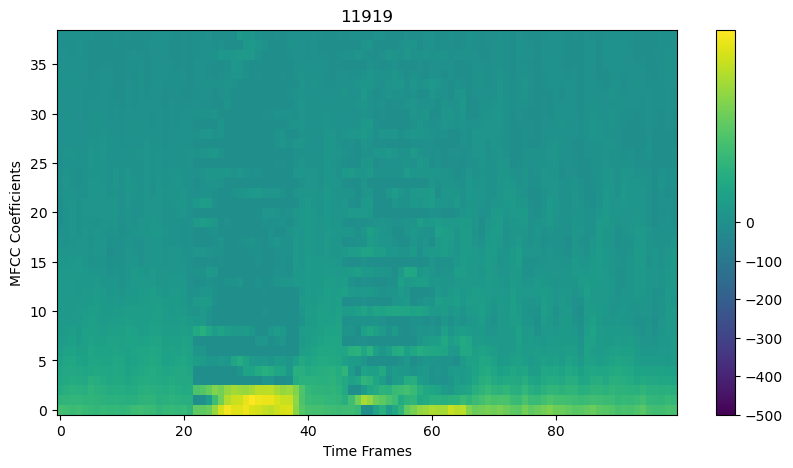

In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

idx = np.random.randint(len(X_train))
mfcc_sample = np.squeeze(X_train[idx])  

norm = mcolors.TwoSlopeNorm(vmin=-500, vcenter=0, vmax=np.max(mfcc_sample))

plt.figure(figsize=(10, 5))
img = plt.imshow(mfcc_sample, aspect='auto', origin='lower', cmap='viridis', norm=norm)
plt.colorbar(img)
plt.title(idx)
plt.xlabel('Time Frames')
plt.ylabel('MFCC Coefficients')
plt.show()


In [ ]:
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (84843, 39, 100, 1)
Validation data shape: (9981, 39, 100, 1)
Testing data shape: (11005, 39, 100, 1)


This is meant to be executed when a satisfactory model is found to use all the data instead of the just the training data. Sadly, the size increases just over the point of what my GPU can handle. We abandoned this, because the feeding the model piece by piece was too slow.

In [ ]:
# # For full training
# X_combined = np.concatenate((X_train, X_val, X_test), axis=0)
# y_combined = np.concatenate((y_train, y_val, y_test), axis=0)

# print("Combined data shape:", X_combined.shape)
# print("Combined labels shape:", y_combined.shape)

Combined data shape: (105829, 39, 100, 1)
Combined labels shape: (105829, 35)


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

model = models.Sequential([
    layers.Input(shape=(MFCC_DIM-1, MAX_MFCC_LENGTH, 1)),  
    layers.Conv2D(64, (5, 5), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2), padding="same"), 
    layers.Conv2D(128, (4, 4), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2), padding="same"),  
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.GlobalAveragePooling2D(),  
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(commands), activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 100, 64)       1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 50, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 25, 128)      0         
 2D)                                                             
  

More complex model (in the end is is not used because of lower speed)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

inputs = layers.Input(shape=(MFCC_DIM-1, MAX_MFCC_LENGTH, 1))

x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  

x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  

x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x) 

x = layers.Reshape((13, 5*128))(x)  
x = layers.Bidirectional(layers.GRU(128, return_sequences=False))(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(commands), activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Generator was used when the dataset was too large to process in one shot. Sadly, it significantly (15-20x) reduces the processing speed. Batching would probably help, but not worth for this dataset. The idea was to use it with the augmented dataset, but all this ultimately take quite a lot of time (in terms of processing and labour) and we concluded that this is beyond the scope of the project.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# def data_generator(X, Y):
#     num_samples = len(X)
#     for i in range(num_samples):
#         yield X[i], Y[i]


# train_ds = tf.data.Dataset.from_generator(
#     lambda: data_generator(X_combined, y_combined),
#     output_signature=(
#         tf.TensorSpec(shape=(39, 100, 1), dtype=X_train.dtype),
#         tf.TensorSpec(shape=(len(commands),), dtype=y_train.dtype)
#     )
# )

# batch_size = 1
# train_ds = train_ds.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=3,               
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
105829/105829 [==============================] - 810s 8ms/step - loss: 2.2547 - accuracy: 0.3970 - val_loss: 1.0027 - val_accuracy: 0.7129
Epoch 2/30
105829/105829 [==============================] - 802s 8ms/step - loss: 0.8919 - accuracy: 0.7387 - val_loss: 0.6002 - val_accuracy: 0.8324
Epoch 3/30
105829/105829 [==============================] - 801s 8ms/step - loss: 0.5804 - accuracy: 0.8325 - val_loss: 0.3883 - val_accuracy: 0.8895
Epoch 4/30
105829/105829 [==============================] - 805s 8ms/step - loss: 0.4488 - accuracy: 0.8708 - val_loss: 0.3150 - val_accuracy: 0.9068
Epoch 5/30
105829/105829 [==============================] - 803s 8ms/step - loss: 0.3767 - accuracy: 0.8914 - val_loss: 0.2768 - val_accuracy: 0.9194
Epoch 6/30
105829/105829 [==============================] - 802s 8ms/step - loss: 0.3290 - accuracy: 0.9055 - val_loss: 0.2413 - val_accuracy: 0.9286
Epoch 7/30
105829/105829 [==============================] - 803s 8ms/step - loss: 0.2993 - accuracy:

KeyboardInterrupt: 

In [ ]:
with tf.device('/CPU:0'):
    # train_loss, train_acc = model.evaluate(X_train, y_train)
    # print(f"Train loss: {train_loss:.2f}; Train Accuracy: {train_acc:.2f}")
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.3f}; Test Accuracy: {test_acc:.3f}")
    # val_loss, val_acc = model.evaluate(X_val, y_val)
    # print(f"Validation loss: {val_loss:.2f}; Validation Accuracy: {val_acc:.2f}")

344/344 [==============================] - 23s 65ms/step - loss: 0.3284 - accuracy: 0.9014
Test loss: 0.328; Test Accuracy: 0.901


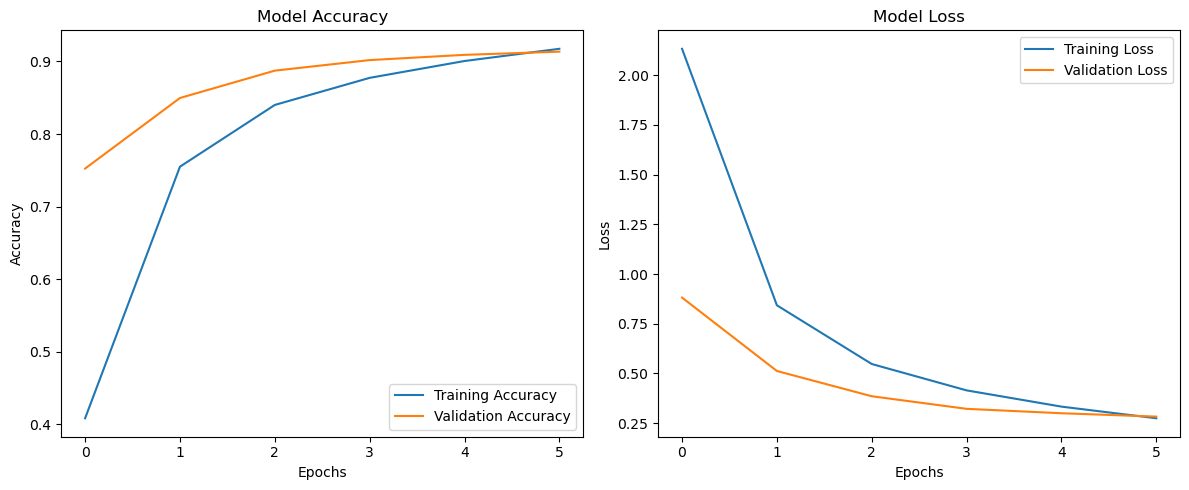

In [ ]:
def plot_model_history(history):

    plt.figure(figsize=(12, 5))
    

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


plot_model_history(history)


In [ ]:
model.save("nfft512_64-5x5_max2_128-4x4_max2_128-3x3_glob_256_0.5dropout_30ep_fulldata.h5")

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved.")


Label encoder saved.


## Evaluation

In [ ]:
with tf.device('/CPU:0'):
    predictions = model.predict(X_train)

344/344 [==============================] - 22s 62ms/step


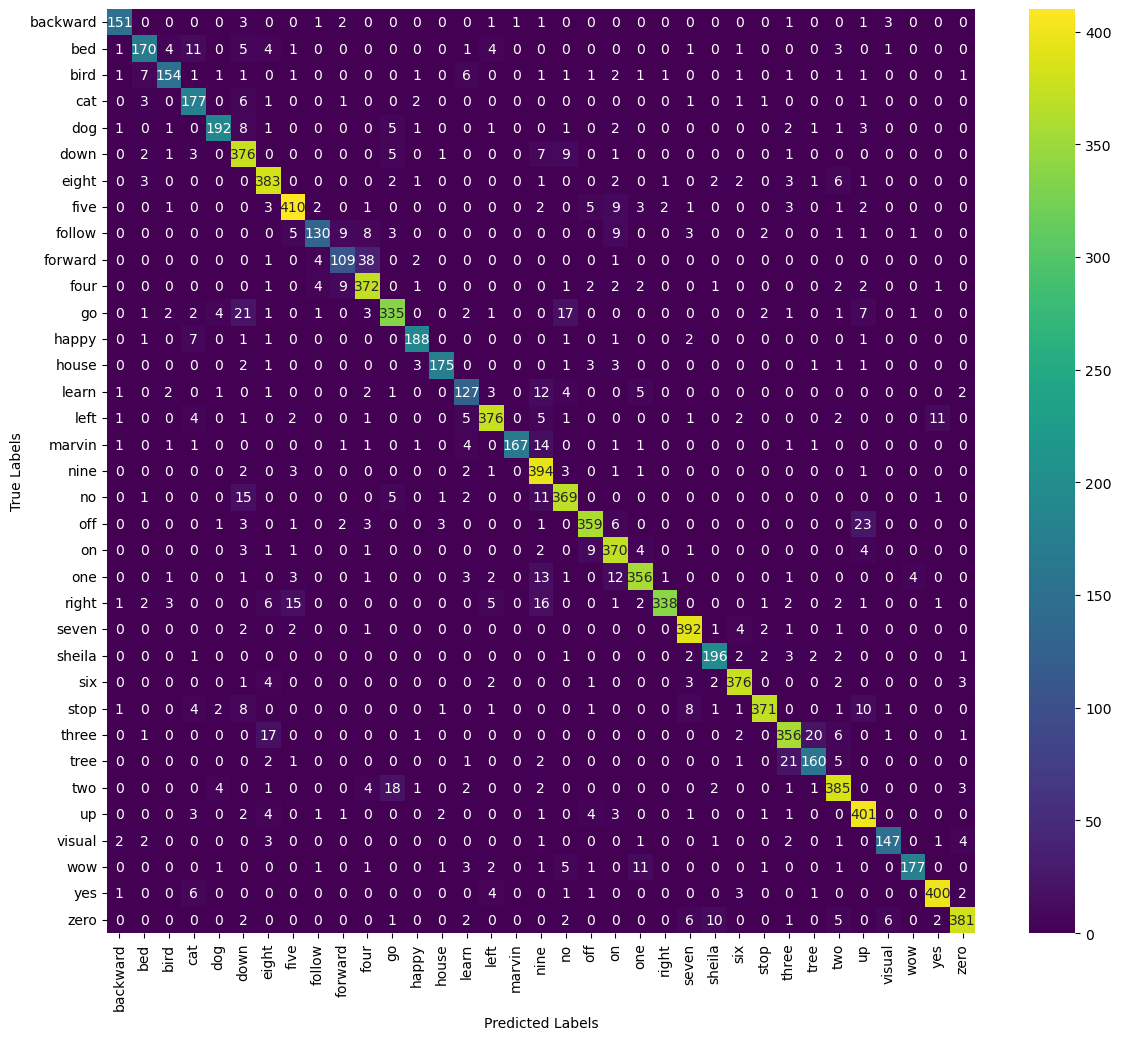

In [ ]:
import seaborn as sns
# google library for hyperparameter sweep (opti-something)

# Perform model prediction
# predictions = model.predict(X_train)  # Shape: (1, num_classes)
# print(f"Raw predictions: {predictions}")

# print(f"Class probabilities: {probabilities}")
class_labels = label_encoder.inverse_transform(range(len(predictions[0])))

if len(y_train.shape) > 1:
    y_train = np.argmax(y_test, axis=-1)
predicted_labels = np.argmax(predictions, axis=-1)
confusion_mtx = tf.math.confusion_matrix(y_train, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(confusion_mtx.numpy(),
            xticklabels=class_labels,
            yticklabels=class_labels, 
            annot=True,
            fmt='g',
            cmap="viridis")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()